In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import pickle
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.2.0
sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)
matplotlib 2.1.2
numpy 1.19.1
pandas 0.22.0
sklearn 0.19.1
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [2]:
# 从本地保存数据文件加载数据
with open(file='data/california_housing.pkl', mode='rb') as f:
    housing=pickle.load(f)
# from sklearn.datasets import fetch_california_housing
# housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [9]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# 此处采用fit_transform是因为，该函数可以将训练集的均值和方差记录下来，这样在验证集和测试集可以保持一致，这样也就保证了数据是同分布的，模型的构建和训练才会有效
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [13]:
# 多输出（当前的房价，一年后的房价）
input_wide = keras.layers.Input(shape=[5])
input_deep = keras.layers.Input(shape=[6])

hidden1 = keras.layers.Dense(30, activation='relu')(input_deep)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
# wide and deep combine
concat = keras.layers.concatenate([input_wide, hidden2])
output = keras.layers.Dense(1)(concat)
output2 = keras.layers.Dense(1)(hidden2)

# 由于使用的是函数式api，所以需要将模型固化下来
model = keras.models.Model(inputs = [input_wide, input_deep],
                           outputs = [output, output2])

model.compile(loss="mean_squared_error", optimizer="sgd")
callbacks = [keras.callbacks.EarlyStopping(
    patience=5, min_delta=1e-2)]
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 30)           210         input_10[0][0]                   
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 30)           930         dense_16[0][0]                   
____________________________________________________________________________________________

In [14]:
x_train_scaled_wide = x_train_scaled[:, :5]
x_train_scaled_deep = x_train_scaled[:, 2:]
x_valid_scaled_wide = x_valid_scaled[:, :5]
x_valid_scaled_deep = x_valid_scaled[:, 2:]
x_test_scaled_wide = x_test_scaled[:, :5]
x_test_scaled_deep = x_test_scaled[:, 2:]

history = model.fit([x_train_scaled_wide, x_train_scaled_deep],
                   [y_train, y_train],
                   validation_data=([x_valid_scaled_wide, x_valid_scaled_deep], [y_valid, y_valid]),
                   epochs=100,
                   callbacks=callbacks,
                   batch_size=32)


Epoch 1/100
363/363 [==============================] - 2s 5ms/step - loss: 2.1373 - dense_18_loss: 0.7636 - dense_19_loss: 1.3737 - val_loss: 2.0857 - val_dense_18_loss: 0.6034 - val_dense_19_loss: 1.4823
Epoch 2/100
363/363 [==============================] - 2s 5ms/step - loss: 1.8057 - dense_18_loss: 0.7230 - dense_19_loss: 1.0827 - val_loss: 1.2304 - val_dense_18_loss: 0.5136 - val_dense_19_loss: 0.7168
Epoch 3/100
363/363 [==============================] - 2s 5ms/step - loss: 1.0213 - dense_18_loss: 0.4324 - dense_19_loss: 0.5890 - val_loss: 0.9969 - val_dense_18_loss: 0.4254 - val_dense_19_loss: 0.5715
Epoch 4/100
363/363 [==============================] - 2s 5ms/step - loss: 0.8866 - dense_18_loss: 0.3899 - dense_19_loss: 0.4967 - val_loss: 0.8773 - val_dense_18_loss: 0.3905 - val_dense_19_loss: 0.4868
Epoch 5/100
363/363 [==============================] - 2s 5ms/step - loss: 0.8255 - dense_18_loss: 0.3669 - dense_19_loss: 0.4586 - val_loss: 0.8874 - val_dense_18_loss: 0.3946 - v

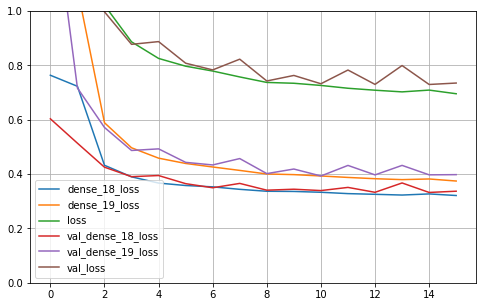

In [15]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

In [16]:
model.evaluate([x_test_scaled_wide, x_test_scaled_deep], [y_test, y_test])

162/162 [==============================] - 0s 3ms/step - loss: 0.7211 - dense_18_loss: 0.3333 - dense_19_loss: 0.3878


[0.7211166024208069, 0.33332422375679016, 0.38779255747795105]